In [1]:
# Which python are we using?
import sys
sys.executable

'/Users/alex/opt/anaconda3/bin/python'

In [2]:
!python --version

Python 3.8.5


In [3]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import json
import folium
import datetime
from ast import literal_eval

sys.path.append('/lib')
import lib.helper as helper

%matplotlib inline
# %load_ext folium_magic

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
ANALYSES_DIR = "data/analyses/"
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

In [35]:
# Absolute or relative path to processed instructor and workshop data that we want to analyse/map (extracted from the Carpentries REDASH)
instructors_file = "data/processed/processed_carpentry_instructors_UK_2020-12-10_redash.csv"
workshops_file = "data/processed/processed_carpentry_workshops_UK_2020-12-10_redash.csv"

In [5]:
instructors_df = pd.read_csv(instructors_file, encoding = "utf-8")
# instructors_df = instructors_df.drop(labels=['first_name', 'last_name'], axis=1)
# load 'taught_workshops_per_year' column as dictionary
instructors_df.loc[~instructors_df['taught_workshops_per_year'].isnull(),['taught_workshops_per_year']] = instructors_df.loc[~instructors_df['taught_workshops_per_year'].isnull(),'taught_workshops_per_year'].apply(lambda x: literal_eval(x))
instructors_df.loc[instructors_df['taught_workshops_per_year'].isnull(),['taught_workshops_per_year']] = instructors_df.loc[instructors_df['taught_workshops_per_year'].isnull(),'taught_workshops_per_year'].apply(lambda x: {})

# Let's change type of some columns and do some conversions

# Convert list of strings into list of dates for 'taught_workshop_dates' and 'earliest_badge_awarded' columns (turn NaN into [])
instructors_df['taught_workshop_dates'] = instructors_df['taught_workshop_dates'].str.split(',')
instructors_df.loc[instructors_df['taught_workshop_dates'].isnull(), ['taught_workshop_dates']] = instructors_df.loc[instructors_df['taught_workshop_dates'].isnull(), 'taught_workshop_dates'].apply(lambda x: [])
instructors_df['taught_workshop_dates'] = instructors_df['taught_workshop_dates'].apply(lambda list_str: [datetime.datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in list_str])

# Convert list of strings into list of dates for ' ' column (turn NaN into [])
instructors_df['taught_workshops'] = instructors_df['taught_workshops'].str.split(',')
instructors_df.loc[instructors_df['taught_workshops'].isnull(), ['taught_workshops']] = instructors_df.loc[instructors_df['taught_workshops'].isnull(), 'taught_workshop_dates'].apply(lambda x: [])

# Convert 'earliest_badge_awarded' column from strings to datetime
instructors_df['earliest_badge_awarded'] = pd.to_datetime(instructors_df['earliest_badge_awarded'], format="%Y-%m-%d").apply(lambda x: x.date())
print(type(instructors_df['earliest_badge_awarded'][0]))

<class 'datetime.date'>


In [6]:
# Let's inspect our instructors data
instructors_df.head(10)

,institution,normalised_institution,latitude,longitude,country,country_code,region,taught_workshops,taught_workshop_dates,taught_workshops_per_year,...,swc-instructor,dc-instructor,lc-instructor,trainer,earliest_badge_awarded,year_earliest_badge_awarded,airport,airport_code,airport_latitude,airport_longitude
0,University College London,UNIVERSITY COLLEGE LONDON,51.524774,-0.133401,United Kingdom,GB,London,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",...,2017-12-08,NaN,NaN,NaN,2017-12-08,2017,London Heathrow,LHR,51.477500,-0.461389
1,NaN,NaN,NaN,NaN,United Kingdom,GB,South West,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},...,2014-11-27,NaN,NaN,NaN,2014-11-27,2014,Exeter,EXT,50.734444,-3.413889
2,University of Edinburgh,UNIVERSITY OF EDINBURGH,55.948003,-3.188111,United Kingdom,GB,Scotland,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",...,2014-12-23,2016-10-06,NaN,NaN,2014-12-23,2014,Edinburgh,EDI,55.950000,-3.372500
3,University of Sussex,UNIVERSITY OF SUSSEX,50.864464,-0.087049,United Kingdom,GB,South East,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",...,NaN,2017-06-08,NaN,NaN,2017-06-08,2017,London Gatwick,LGW,51.148056,-0.190278
4,University of Oxford,UNIVERSITY OF OXFORD,51.757644,-1.262868,United Kingdom,GB,South East,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",...,2014-05-09,2016-11-15,NaN,NaN,2014-05-09,2014,London Heathrow,LHR,51.477500,-0.461389
5,The University of Manchester,THE UNIVERSITY OF MANCHESTER,53.467943,-2.233222,United Kingdom,GB,North West,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",...,2019-01-07,NaN,NaN,NaN,2019-01-07,2019,Manchester,MAN,53.353611,-2.274722
6,"EPCC, University of Edinburgh",UNIVERSITY OF EDINBURGH,55.948003,-3.188111,United Kingdom,GB,Scotland,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 3}",...,2015-05-26,2016-01-27,NaN,NaN,2015-05-26,2015,Edinburgh,EDI,55.950000,-3.372500
7,University of Edinburgh,UNIVERSITY OF EDINBURGH,55.948003,-3.188111,United Kingdom,GB,Scotland,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",...,2014-07-22,NaN,NaN,NaN,2014-07-22,2014,Edinburgh,EDI,55.950000,-3.372500
8,British Trust for Ornithology,BRITISH TRUST FOR ORNITHOLOGY,NaN,NaN,United Kingdom,GB,Eastern,[],[],{},...,2017-12-08,NaN,NaN,NaN,2017-12-08,2017,Stansted,STN,51.885000,0.235000
9,University of Cambridge,UNIVERSITY OF CAMBRIDGE,52.205317,0.116642,United Kingdom,GB,Eastern,[2017-01-18-CAM],[2017-01-18],{2017: 1},...,2016-11-11,2016-11-11,NaN,NaN,2016-11-11,2016,Stansted,STN,51.885000,0.235000


In [7]:
# Let's inspect our data a bit more
print("Columns: ")
print(instructors_df.columns)

print("\nData types: ")
print(instructors_df.dtypes)

print("\nExpecting a list for 'taught_workshop_dates' column: ")
print(type(instructors_df['taught_workshop_dates'][0]))

print("\nExpecting dates in the list in 'taught_workshop_dates' column: ")
print(instructors_df['taught_workshop_dates'][0])

print("\nExpecting datetime for 'earliest_badge_awarded' column: ")
print(instructors_df['earliest_badge_awarded'][0])

print("\n'earliest_badge_awarded' column should not have nulls:")
print(instructors_df[instructors_df['earliest_badge_awarded'].isnull()])

print("\nWhich instructors have null for institution?")
print(instructors_df[instructors_df['institution'].isna()].index)

print("\nWhich instructors have null for region?")
print(instructors_df[instructors_df['region'].isna()].index)

print("\nWhich instructors have null for geo-coordinates?")
print(instructors_df[instructors_df['longitude'].isna()].index)

Columns: 
Index(['institution', 'normalised_institution', 'latitude', 'longitude',
       'country', 'country_code', 'region', 'taught_workshops',
       'taught_workshop_dates', 'taught_workshops_per_year', 'domains',
       'badges', 'badges_dates', 'swc-instructor', 'dc-instructor',
       'lc-instructor', 'trainer', 'earliest_badge_awarded',
       'year_earliest_badge_awarded', 'airport', 'airport_code',
       'airport_latitude', 'airport_longitude'],
      dtype='object')

Data types: 
institution                     object
normalised_institution          object
latitude                       float64
longitude                      float64
country                         object
country_code                    object
region                          object
taught_workshops                object
taught_workshop_dates           object
taught_workshops_per_year       object
domains                         object
badges                          object
badges_dates                    ob

In [8]:
# How many instructors are there in total?
instructors_df.index.size

284

In [9]:
# Get the date of the last taught workshop
instructors_workshops_df = pd.DataFrame(instructors_df[['taught_workshops', 'taught_workshop_dates', 'taught_workshops_per_year', 'earliest_badge_awarded']])
instructors_workshops_df['last_taught_workshop_date'] = instructors_workshops_df['taught_workshop_dates'].apply(lambda x: max(x) if (x != []) else None)
instructors_workshops_df.head(10)

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-11-25
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-01-07,2019-10-21
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 3}",2015-05-26,2020-05-26
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-07-22,2014-02-18
8,[],[],{},2017-12-08,None
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2016-11-11,2017-01-18


In [12]:
# Extract column for each year containing number of workshops taught that year by instructor 
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for year in years: 
    instructors_workshops_df[year] = instructors_workshops_df['taught_workshops_per_year'].apply(lambda x: x.get(int(year), 0))
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,avarage_taught_workshops_per_year
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18,0,0,0,0,1,2,1,0,1,0,1.25
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28,0,0,0,2,0,0,0,0,0,0,2.00
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-11-25,0,2,1,3,3,2,1,4,6,0,2.75
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14,0,0,0,1,0,4,1,0,0,0,2.00
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14,0,0,1,0,1,1,1,1,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,[2020-11-02-cardiff-online],[2020-11-02],{2020: 1},2020-10-01,2020-11-02,0,0,0,0,0,0,0,0,1,0,1.00
280,[],[],{},2020-09-28,None,0,0,0,0,0,0,0,0,0,0,NaN
281,[],[],{},2020-11-30,None,0,0,0,0,0,0,0,0,0,0,NaN
282,[],[],{},2020-11-16,None,0,0,0,0,0,0,0,0,0,0,NaN


In [13]:
# Average number of workshop taught across all active years
instructors_workshops_df['avarage_taught_workshops_per_year'] = instructors_workshops_df[years].replace(0, np.NaN).mean(axis=1)
# instructors_workshops_df['avarage_taught_workshops_per_year'] = instructors_workshops_df['avarage_taught_workshops_per_year'].replace(np.NaN, 0)
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,avarage_taught_workshops_per_year
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18,0,0,0,0,1,2,1,0,1,0,1.25
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28,0,0,0,2,0,0,0,0,0,0,2.00
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-11-25,0,2,1,3,3,2,1,4,6,0,2.75
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14,0,0,0,1,0,4,1,0,0,0,2.00
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14,0,0,1,0,1,1,1,1,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,[2020-11-02-cardiff-online],[2020-11-02],{2020: 1},2020-10-01,2020-11-02,0,0,0,0,0,0,0,0,1,0,1.00
280,[],[],{},2020-09-28,None,0,0,0,0,0,0,0,0,0,0,NaN
281,[],[],{},2020-11-30,None,0,0,0,0,0,0,0,0,0,0,NaN
282,[],[],{},2020-11-16,None,0,0,0,0,0,0,0,0,0,0,NaN


In [14]:
# print(instructors_workshops_df.dtypes)
# print(instructors_workshops_df['taught_workshop_dates'][0])
# print(type(instructors_workshops_df['last_taught_workshop_date'][0]))
# print(instructors_workshops_df.index)
# instructors_workshops_df

In [15]:
# How many instructors taught 0 times?
len(instructors_workshops_df[instructors_workshops_df['last_taught_workshop_date'].isnull()].index)

112

In [16]:
# Let's define active and inactive instructors
# Active = taught in the past 2 years. Inactive = everyone else.
def is_active(taught_workshop_dates):
    if taught_workshop_dates == [] or (datetime.date.today() - max(taught_workshop_dates)).days > 712:
        return False
    else:
        return True
    
instructors_workshops_df['is_active'] = instructors_workshops_df['taught_workshop_dates'].apply(lambda x: is_active(x))
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,earliest_badge_awarded,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,avarage_taught_workshops_per_year,is_active
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-25, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2017-12-08,2020-02-18,0,0,0,0,1,2,1,0,1,0,1.25,True
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2014-11-27,2015-09-28,0,0,0,2,0,0,0,0,0,0,2.00,False
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2014-12-23,2020-11-25,0,2,1,3,3,2,1,4,6,0,2.75,True
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2017-06-08,2018-05-14,0,0,0,1,0,4,1,0,0,0,2.00,False
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2014-05-09,2019-05-14,0,0,1,0,1,1,1,1,0,0,1.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,[2020-11-02-cardiff-online],[2020-11-02],{2020: 1},2020-10-01,2020-11-02,0,0,0,0,0,0,0,0,1,0,1.00,True
280,[],[],{},2020-09-28,None,0,0,0,0,0,0,0,0,0,0,NaN,False
281,[],[],{},2020-11-30,None,0,0,0,0,0,0,0,0,0,0,NaN,False
282,[],[],{},2020-11-16,None,0,0,0,0,0,0,0,0,0,0,NaN,False


Number of active instructors: 96
Number of inactive instructors: 188
False    188
True      96
Name: is_active, dtype: int64


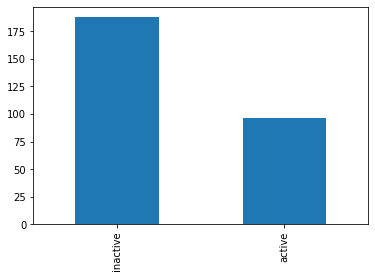

In [77]:
# How many active and inactive instructors?
active = instructors_workshops_df[instructors_workshops_df['is_active'] == True]
inactive = instructors_workshops_df[instructors_workshops_df['is_active'] != True]
print("Number of active instructors: " + str(len(active.index)))
print("Number of inactive instructors: " + str(len(inactive.index)))
active_vs_inactive = instructors_workshops_df['is_active'].value_counts()
print(active_vs_inactive)
active_vs_inactive.index = ['inactive', 'active']
active_vs_inactive.rename('number_of_instructors', inplace = True)
plot = active_vs_inactive.plot(kind='bar')
# plot.set_xticklabels(['inactive', 'active'])

2012    2.142857
2013    1.866667
2014    1.590909
2015    1.827586
2016    2.090909
2017    1.964286
2018    1.621212
2019    1.853659
2020    2.083333
dtype: float64


<AxesSubplot:>

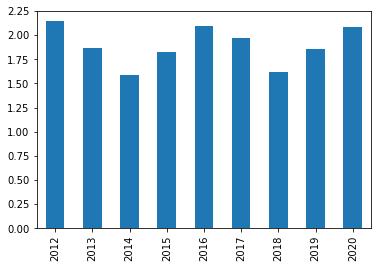

In [19]:
# Average number of workshops taught per year (for all instructors)
average_workshops_per_year_all = instructors_workshops_df[years].replace(0, np.NaN).mean(axis=0)
print(average_workshops_per_year_all)
average_workshops_per_year_all.plot(kind='bar')

In [20]:
# Average number of workshops taught across all active years (for all instructors)
average_workshops_per_year_all.mean()

1.8934908781838975

<AxesSubplot:>

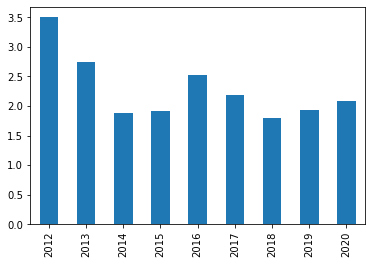

In [21]:
# Average number of workshops taught per year (for active instructors only)
average_workshops_per_year_active = active[years].replace(0, np.NaN).mean(axis=0)
average_workshops_per_year_active.plot(kind='bar')

In [22]:
# Average number of workshops taught across all active years (for active instructors only)
average_workshops_per_year_active.mean()

2.286390760725766

<AxesSubplot:>

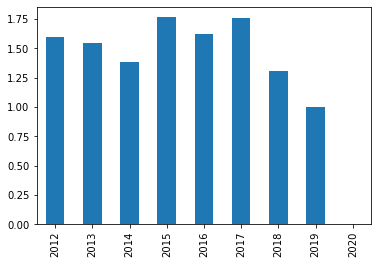

In [23]:
# Average number of workshops taught per year (for inactive instructors only)
average_workshops_per_year_inactive = inactive[years].replace(0, np.NaN).mean(axis=0)
average_workshops_per_year_inactive = average_workshops_per_year_inactive.replace(np.nan, 0)
average_workshops_per_year_inactive.plot(kind='bar')

In [24]:
# Average number of workshops taught across all active years (for inactive instructors only)
average_workshops_per_year_inactive.mean()

1.3314160364627776

In [25]:
# How long have instructors that are inactive now been active for? 
# In other words, how long do they teach before they become inactive?
def activity_days_for_inactive(date_list):
    return (max(date_list) - min(date_list)).days

print("Number of inactive instructors: " + str(len(inactive.index)))
time_before_inactivity = inactive[inactive['taught_workshop_dates'].apply(lambda x: len(x)) > 0]# exclude instructors that taught 0 workshops
print("Number of inactive instructors that taught at least 1 workshop: " + str(len(time_before_inactivity.index)))
time_before_inactivity = time_before_inactivity['taught_workshop_dates'].apply(lambda x: activity_days_for_inactive(x))
time_before_inactivity = time_before_inactivity.replace(0, np.NaN)
print("\nAverage period of teaching activity (for currently inactive instructors that taught at least 1 workshop): " + str(time_before_inactivity.mean()) + " days.")

Number of inactive instructors: 188
Number of inactive instructors that taught at least 1 workshop: 76

Average period of teaching activity (for currently inactive instructors that taught at least 1 workshop): 486.73333333333335 days.


In [27]:
# How long have instructors that are active now been active for? 
# In other words, what is the current period of activity for active instuctors up to now
def activity_days_for_active(date_list):
    return (datetime.date.today() - min(date_list)).days
    
period_of_activity = active['taught_workshop_dates'].apply(lambda x: activity_days_for_active(x))
print("Number of active instructors: " + str(len(period_of_activity.index)))
period_of_activity = period_of_activity.replace(0, np.NaN)
print("\nAverage period of teaching activity up till now (for currently active instructors): " + str(period_of_activity.mean()) + " days.")

Number of active instructors: 96

Average period of teaching activity up till now (for currently active instructors): 994.28125 days.


In [28]:
# How long have all instructors been active for on average? 
# In other words, what is the period of teaching activity for all instuctors
period_of_activity_all = instructors_workshops_df[instructors_workshops_df['taught_workshop_dates'].apply(lambda x: len(x) > 0)]# exclude instructors that taught 0 workshops
print("Number of active and inactive instructors (that taught at least 1 workshop): " + str(len(period_of_activity_all.index)))
period_of_activity_all = period_of_activity_all.apply(lambda x: activity_days_for_active(x['taught_workshop_dates']) if x['is_active'] else activity_days_for_inactive(x['taught_workshop_dates']), axis = 1)
period_of_activity_all = period_of_activity_all.replace(0, np.NaN)
print("\nAverage period of teaching activity (for all instructors that taught at least 1 workshop): " + str(period_of_activity_all.mean()) + " days.")
# period_of_activity_all

Number of active and inactive instructors (that taught at least 1 workshop): 172

Average period of teaching activity (for all instructors that taught at least 1 workshop): 832.2978723404256 days.


In [29]:
# How long from becoming an instructor to teaching for the first time on average?
def time_before_first_workshop(date, dates_list):
    if dates_list != []:
        days = min(dates_list) - date
        if days.days > 0: # disregard those instructors who were teaching before officially qualifying as instructors
            return days.days
    return np.NaN
    
instructors_workshops_df['days_to_first_workshop'] = instructors_workshops_df.apply(lambda x: time_before_first_workshop(x['earliest_badge_awarded'], x['taught_workshop_dates']), axis=1)
print("\nAverage period between becoming an instructor and teaching for the first time: " + str(instructors_workshops_df['days_to_first_workshop'].mean()) + " days.")


Average period between becoming an instructor and teaching for the first time: 196.67469879518072 days.


      number_of_instructors
year                       
2012                      5
2013                     10
2014                     22
2015                     21
2016                     25
2017                     46
2018                     40
2019                     64
2020                     51


<AxesSubplot:title={'center':'Instructors per year'}, xlabel='year'>

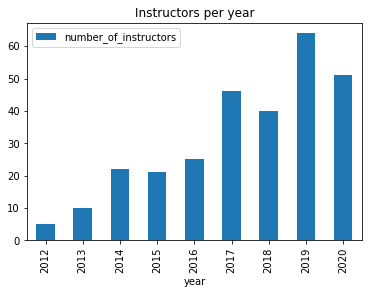

In [30]:
# How many new instructors are there for each year?
instructors_per_year = instructors_df['year_earliest_badge_awarded'].value_counts()
instructors_per_year.sort_index(ascending = True, inplace=True)
instructors_per_year.index.name = 'year'
instructors_per_year = instructors_per_year.to_frame('number_of_instructors')
print(instructors_per_year)
instructors_per_year.plot(kind='bar', legend=True, title ="Instructors per year")

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='int64', name='year')
      number_of_workshops
year                     
2012                    7
2013                   14
2014                   20
2015                   31
2016                   40
2017                   52
2018                   61
2019                   85
2020                   54


<AxesSubplot:title={'center':'Workshops per year'}, xlabel='year'>

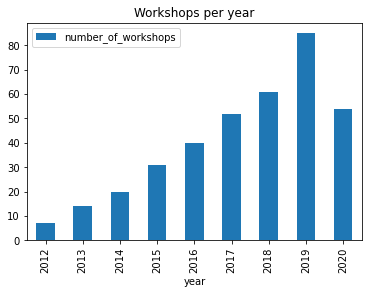

In [60]:
# Let's look how many workshops are these instructors teaching per year?
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")

workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
workshops_per_year.index = workshops_per_year.index.astype('int64') 
print(workshops_per_year.index)
# drop data for year 2021
workshops_per_year.drop(labels=[2021], inplace = True)
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

In [61]:
# Total number of workshops
total_workshops = workshops_df.index.size
print("Total number of workshops: " + str(total_workshops))

Total number of workshops: 365


      number_of_learners
year                    
2012                 140
2013                 280
2014                 400
2015                 620
2016                 800
2017                1040
2018                1220
2019                1700
2020                1080


<AxesSubplot:title={'center':'Approx. learners per year'}, xlabel='year'>

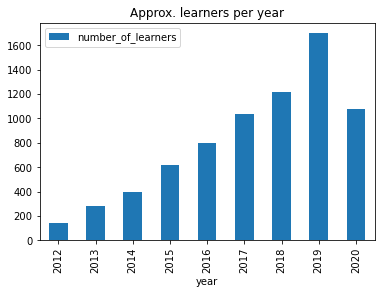

In [103]:
# Approximate number of people taught over years
learners_per_year = workshops_per_year * 20
learners_per_year.rename(columns = {'number_of_workshops' : 'number_of_learners'}, inplace = True)
print(learners_per_year)
learners_per_year.plot(kind='bar', legend=True, title ="Approx. learners per year")

In [63]:
# Approximate total number of learners @ 20 attendees per workshop
total_learners = 20 * total_workshops
print("Approximate number of people taught: " + str(total_learners))

Approximate number of people taught: 7300


In [105]:
# Save all analyses into an Excel spreadsheet
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

outcome_113_excel_file = ANALYSES_DIR + 'outcome_113.xlsx'

excel_writer = pd.ExcelWriter(outcome_113_excel_file, engine='xlsxwriter')

outcome_sheet = 'Outcome 1.1.3'

# Instructors per year
sheet_row = 1
instructors_per_year.to_excel(excel_writer, sheet_name=outcome_sheet, startrow=sheet_row - 1, startcol=0, index=True)

workbook = excel_writer.book
worksheet = excel_writer.sheets[outcome_sheet]

chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': [outcome_sheet, sheet_row, 0, len(instructors_per_year.index), 0],
        'values': [outcome_sheet, sheet_row, 1, len(instructors_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per year'})
worksheet.insert_chart('K' + str(sheet_row), chart)
worksheet.write(sheet_row + len(instructors_per_year.index), 0, "Total: ")
worksheet.write(sheet_row + len(instructors_per_year.index), 1,  instructors_per_year['number_of_instructors'].sum())

# Active vs inactive instructors
sheet_row = 21
active_vs_inactive.to_excel(excel_writer, sheet_name=outcome_sheet, startrow=sheet_row-1, startcol=0, index=True)
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': [outcome_sheet, sheet_row, 0, sheet_row - 1 + len(active_vs_inactive.index), 0],
        'values': [outcome_sheet, sheet_row, 1, sheet_row - 1 + len(active_vs_inactive.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Activity type'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Active vs inactive instructors'})
worksheet.insert_chart('K' + str(sheet_row), chart)

# Workshops per year
sheet_row = 41
workshops_per_year.to_excel(excel_writer, sheet_name=outcome_sheet, startrow=sheet_row-1, startcol=0, index=True)
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': [outcome_sheet, sheet_row, 0, sheet_row - 1 + len(workshops_per_year.index), 0],
        'values': [outcome_sheet, sheet_row, 1, sheet_row - 1 + len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Workshops per year'})
worksheet.insert_chart('K' + str(sheet_row), chart)
worksheet.write(sheet_row + len(workshops_per_year.index), 0, "Total: ")
worksheet.write(sheet_row + len(workshops_per_year.index), 1,  workshops_per_year['number_of_workshops'].sum())

# Learners per year
sheet_row = 61
learners_per_year.to_excel(excel_writer, sheet_name=outcome_sheet, startrow=sheet_row-1, startcol=0, index=True)
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': [outcome_sheet, sheet_row, 0, sheet_row - 1 + len(learners_per_year.index), 0],
        'values': [outcome_sheet, sheet_row, 1, sheet_row - 1 + len(learners_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of learners', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Approximate number of learners per year'})
worksheet.insert_chart('K' + str(sheet_row), chart)
worksheet.write(sheet_row + len(learners_per_year.index), 0, "Total: ")
worksheet.write(sheet_row + len(learners_per_year.index), 1,  learners_per_year['number_of_learners'].sum())

excel_writer.save()
print("Saved instructors analyses in " + outcome_113_excel_file)

Saved instructors analyses in data/analyses/outcome_113.xlsx
